### This is an R2OpenBUGS program for the artificial example in Chapter 4, Section 4.5.

Model: Standard Structural Equation Model
Data Set Name: YO.dat
Sample Size: N=300

In [15]:
source(".Rprofile")



#### (A) Codes for specification of the model using R language

In [16]:
model  <- function() {
    for(i in 1:N){
        #measurement equation model
        for(j in 1:P){
            y[i,j] ~ dnorm(mu[i,j],psi[j])
            ephat[i,j] <- y[i,j] - mu[i,j]
        }
        mu[i,1] <- eta[i]+alp[1]
        mu[i,2] <- lam[1] * eta[i] + alp[2]
        mu[i,3] <- lam[2] * eta[i] + alp[3]
        mu[i,4] <- xi[i,1] + alp[4]
        mu[i,5] <- lam[3] * xi[i,1] + alp[5]
        mu[i,6] <- lam[4] * xi[i,1] + alp[6]
        mu[i,7] <- xi[i,2] + alp[7]
        mu[i,8] <- lam[5] * xi[i,2] + alp[8]
        mu[i,9] <- lam[6] * xi[i,2] + alp[9]

        #structural equation model
        xi[i,1:2] ~ dmnorm(u[1:2], phi[1:2,1:2])
        eta[i] ~ dnorm(nu[i], psd)
        nu[i] <- gam[1] * xi[i,1] + gam[2] * xi[i,2]
        dthat[i] <- eta[i] - nu[i]
    } #end of i

    #priors on intercepts
    for(j in 1:9){alp[j]~dnorm(0.0, 1.0)}

    #priors on loadings and coefficients
    lam[1] ~ dnorm(0.8, psi[2])
    lam[2] ~ dnorm(0.8, psi[3])
    lam[3] ~ dnorm(0.8, psi[5])
    lam[4] ~ dnorm(0.8, psi[6])
    lam[5] ~ dnorm(0.8, psi[8])
    lam[6] ~ dnorm(0.8, psi[9])
    for(j in 1:2){ gam[j] ~ dnorm(0.5, psd) }
    
    #priors on precisions
    for(j in 1:P){
        psi[j] ~ dgamma(9.0, 4.0)
        sgm[j] <- 1/psi[j]
    }
    psd ~ dgamma(9.0, 4.0)
    sgd <- 1/psd
    phi[1:2,1:2] ~ dwish(R[1:2,1:2], 5)
    phx[1:2,1:2] <- inverse(phi[1:2, 1:2])

} #end of model

write.model(model, con = "./Chapter4/ch4-R2OpenBUGS-model.txt")
model <- paste0(getwd(), "/Chapter4/ch4-R2OpenBUGS-model.txt")

#### (B) Check model

`bugs()` will autmatically check if model is syntactically correct. If
there are no errors, then the message *"model is syntactically correct"* will be printed in `log.txt` in the session's `tempdir()` or the directory defined in the `bugs()` function's `working.directory` argument.

#### (C) Load data

Read in dataset and save data object in the following format:

In [17]:
# Read in dataset as unnamed matrix
ch4.dat <- read.csv("./Chapter4/ch4-WinBUGS-data.dat", header = FALSE, skip = 2)[,1:9] %>% 
as.matrix()  %>% 
unname()

# Save data as list in the following format
data <- list(
   N = 300,
   P = 9,
   u = c(0,0),
   y = ch4.dat,
   R = structure(
      .Data=c( 1.0, 0.0,
               0.0, 1.0),
      .Dim = c(2,2))
)

The data will be loaded by `bugs()`' first argument `data`. When the data have been successfully loaded, the message *"data loaded"* should appear in the log file.

#### (D) Compile model

By default, `bugs()` simulate three chains of observations with three different sets of initial values (`n.chains = 3`). To change to a different number of Markov chains, add a different value to the `n.chains` argument. For this example the author used three chains, and the parameter can be left unchanged.

`bugs()` automatically compiles the model. If successful, the message "model
compiled" should appear in the log file.


#### (E) Load initial values

Initial values is stored as a function without input, which will be entered as `bugs()` second argument:

In [18]:
# Three different initial values
inits <- function() {
   list(alp = c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
      lam = c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
      psi = c(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0),
      psd = 1.0,
      gam = c(1.0, 1.0),
      phi = structure(
         .Data = c(  0.2, 0.1,
                     0.1, 0.9),
         .Dim = c(2,2)
      )
   )

   list(alp = c(-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0),
      lam = c(-1.0, 0.0, 0.3, 0.6, 0.9, 1.0),
      psi = c(1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5),
      psd = 1.5,
      gam = c(-1.0,-1.0),
      phi = structure(
         .Data = c(  0.5, 0.2,
                     0.2, 0.6),
         .Dim = c(2,2)
      )
   )

   list(alp = c(2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0),
      lam = c(1.0, 0.3, 0.4, 0.5, 1.0, -1.0),
      psi = c(0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3),
      psd = 0.3,
      gam = c(2.0, 2.0),
      phi = structure(
         .Data = c(  0.9, 0.3,
                     0.3, 0.8),
         .Dim = c(2,2)
      )
   )
}

This is necessary to generate the nodes `xi`'s in the MCMC algorithm.
If the model is fully initialized after loading the initial values, then a message
saying *"initial values loaded: model initialized'* will appear in the log file. Otherwise, the message *"initial values loaded: model contains uninitialized nodes"* will appear.

#### (F) Run simulation and check convergence

##### **Step 1: Input the monitored parameters**

`bugs()` third argument, `parameters.to.save`, stores the parameters to be
monitored as a character vector:

In [19]:
param <- c("alp", "lam", "psi", "phi", "gam", "xi")

##### **Step 2: Sample observations for the monitored node**

`bugs()`fourth argument, `n.iter`, stores the total number of MCMC iterations (for example, 5000 or 10000; the default value is 2000).

In [20]:
n.iter <- 5000

The argument `n.thin` sets the thinning rate (for example, k, i.e., the samples from every k-th iteration can be stored) into the box marked thin. The default is 1.

When the run finishes, the message `updates took ***s' will appear in the log file.

##### **Step 3: Check convergence**

The first few thousand iterations should be treated as burn-in iterations.
This is carried out by specifying the number in the `n.burnin` argument. The remaining iteration will be used to obtain the Bayesian statistics.

In [21]:
n.burnin  <- 2000

In order to check whether the algorithm has converged:
 1. Run `bugs()` with the parameter `codaPkg = TRUE`. File names of OpenBUGS output are then returned for easy access by the coda package through the `read.bugs()` function.
 2. Plot coda output files (e.g. using `plot()`) to show the simulated observations against the number of iterations for all of the defined parameters in the `parameters.to.save` argument.

In [8]:
model.out <- R2WinBUGS::bugs(
    data, 
    inits, 
    param[-6], 
    model.file = model,
    n.iter = n.iter,
    n.burnin = n.burnin,
    n.thin = 1,
    codaPkg = TRUE,
    bugs.directory = paste0(Sys.getenv("HOME"), "/.wine/drive_c/Program Files (x86)/WinBUGS14/"),
    program = "WinBUGS",
    working.directory = paste0(getwd(), "/Chapter6/bugs-output"),
    WINE = "/usr/bin/wine",
    WINEPATH = "/usr/bin/winepath"
)

Registered S3 methods overwritten by 'R2WinBUGS':
  method            from      
  print.bugs        R2OpenBUGS
  plot.bugs         R2OpenBUGS
  as.mcmc.list.bugs R2OpenBUGS



Abstracting alp[1] ... 3000 valid values
Abstracting alp[2] ... 3000 valid values
Abstracting alp[3] ... 3000 valid values
Abstracting alp[4] ... 3000 valid values
Abstracting alp[5] ... 3000 valid values
Abstracting alp[6] ... 3000 valid values
Abstracting alp[7] ... 3000 valid values
Abstracting alp[8] ... 3000 valid values
Abstracting alp[9] ... 3000 valid values
Abstracting deviance ... 3000 valid values
Abstracting gam[1] ... 3000 valid values
Abstracting gam[2] ... 3000 valid values
Abstracting lam[1] ... 3000 valid values
Abstracting lam[2] ... 3000 valid values
Abstracting lam[3] ... 3000 valid values
Abstracting lam[4] ... 3000 valid values
Abstracting lam[5] ... 3000 valid values
Abstracting lam[6] ... 3000 valid values
Abstracting phi[1,1] ... 3000 valid values
Abstracting phi[1,2] ... 3000 valid values
Abstracting phi[2,1] ... 3000 valid values
Abstracting phi[2,2] ... 3000 valid values
Abstracting psi[1] ... 3000 valid values
Abstracting psi[2] ... 3000 valid values
Abstra

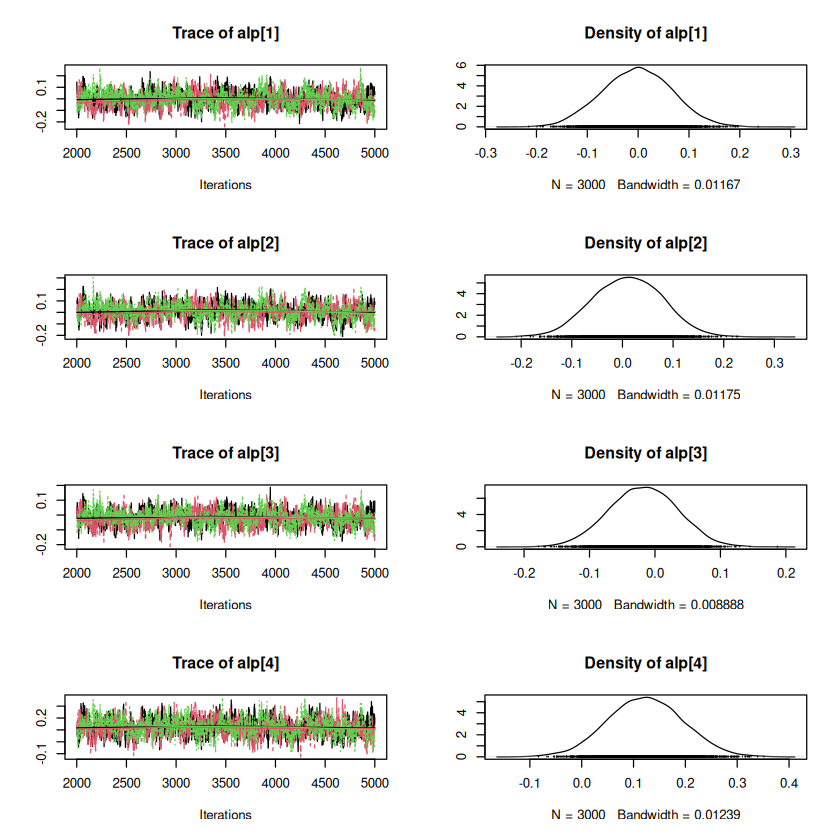

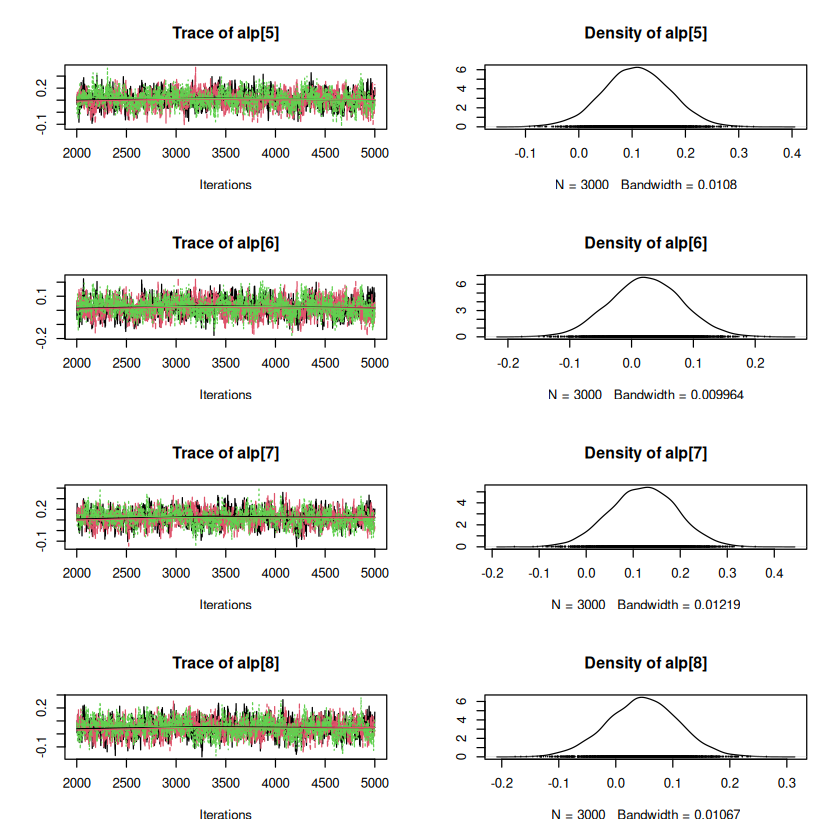

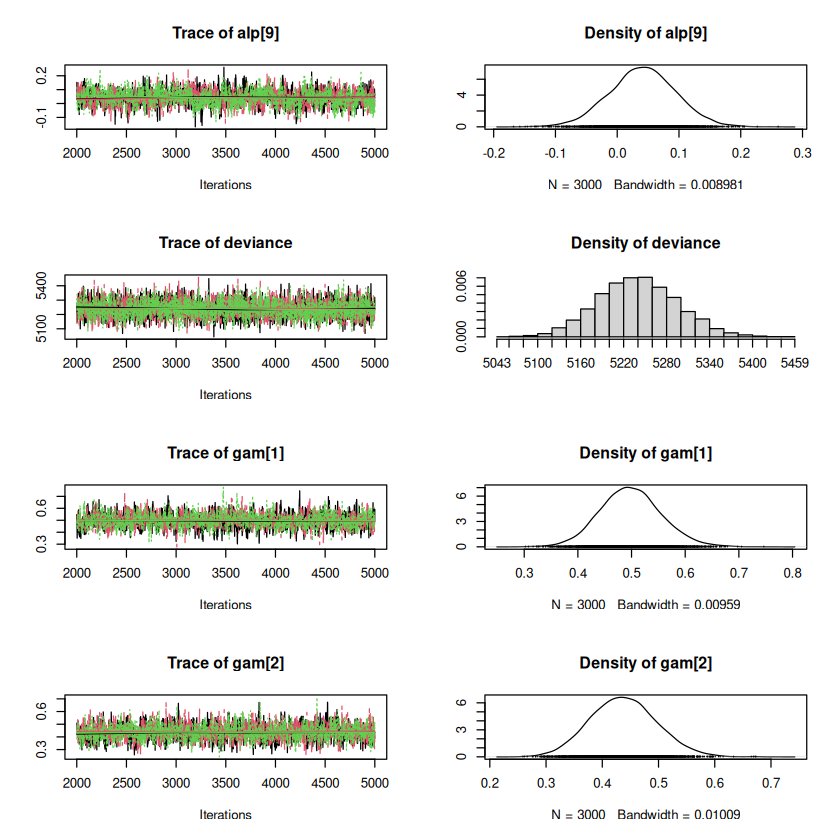

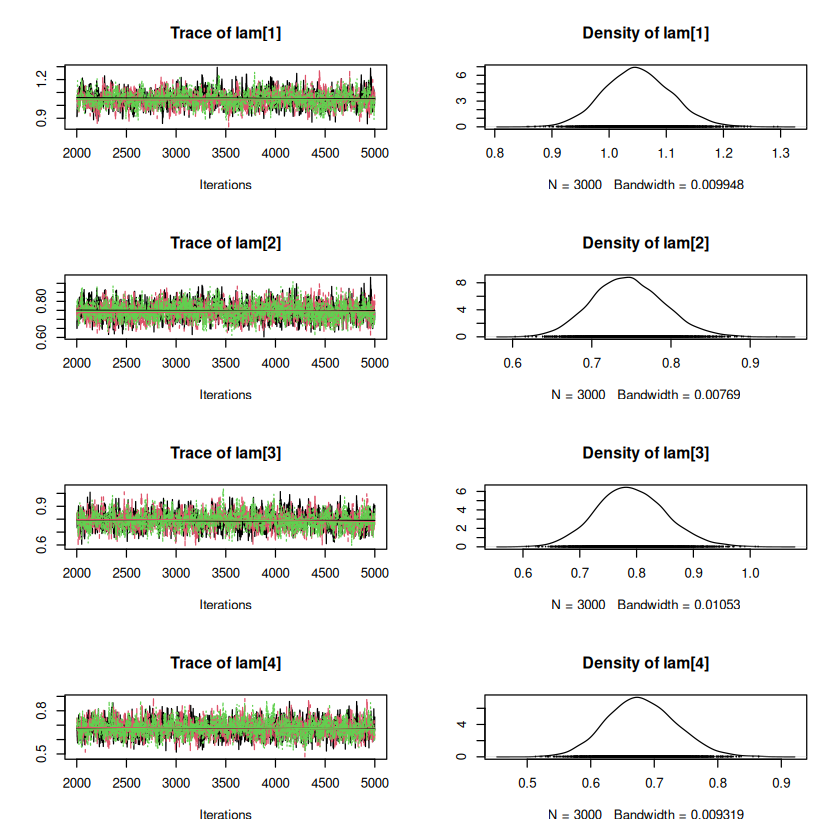

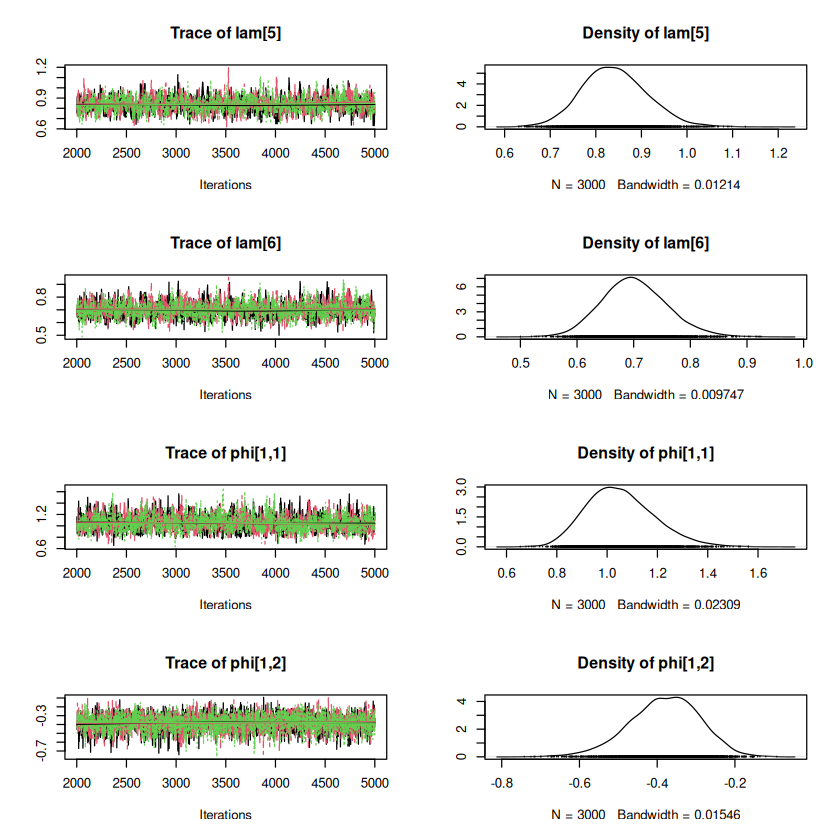

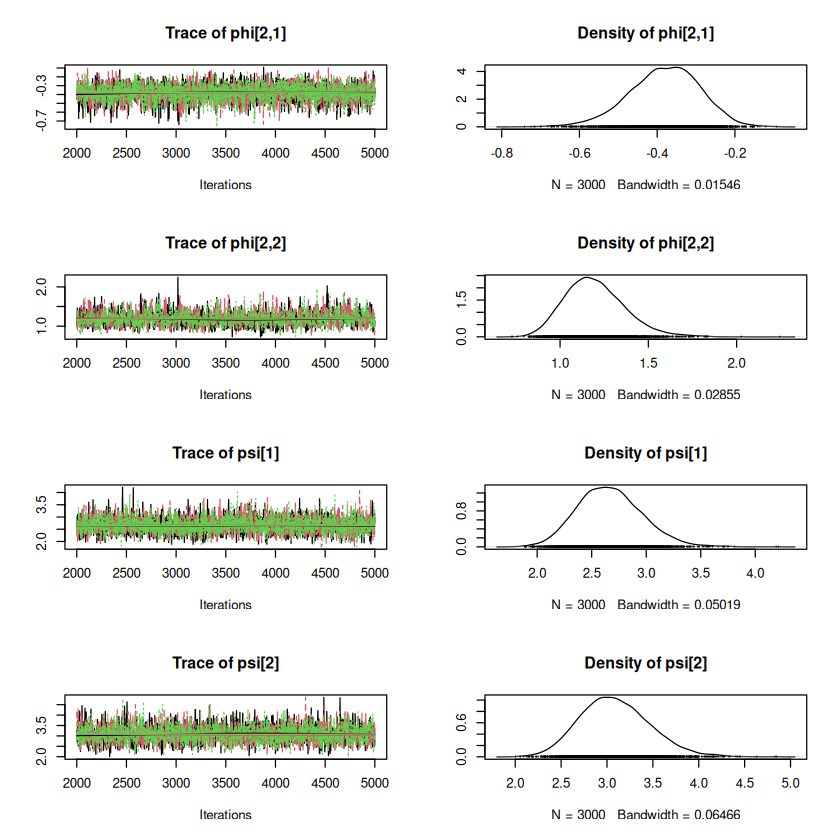

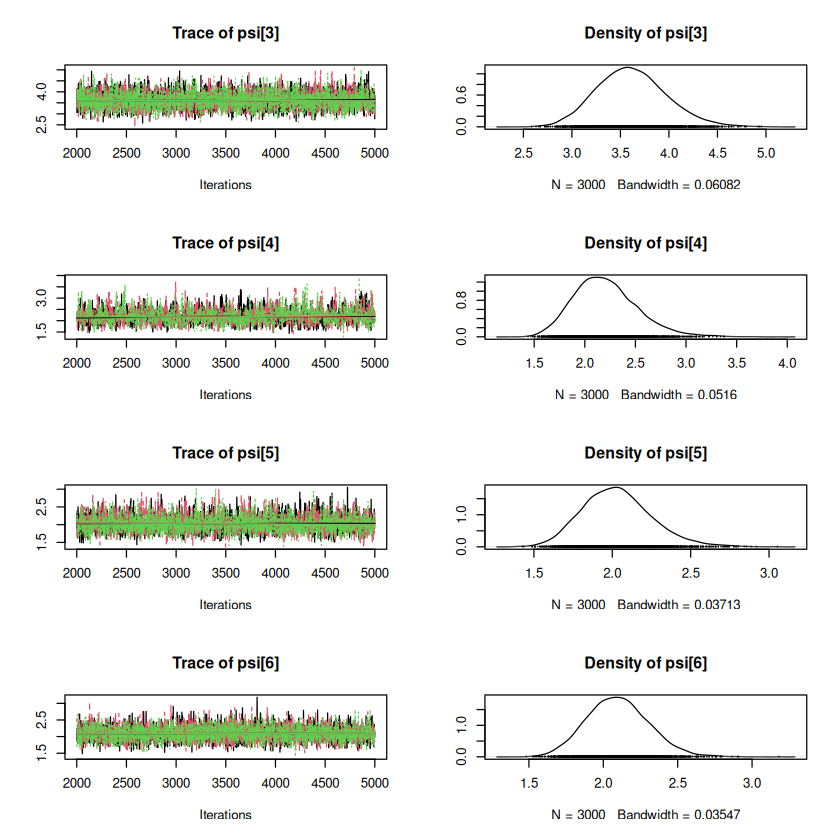

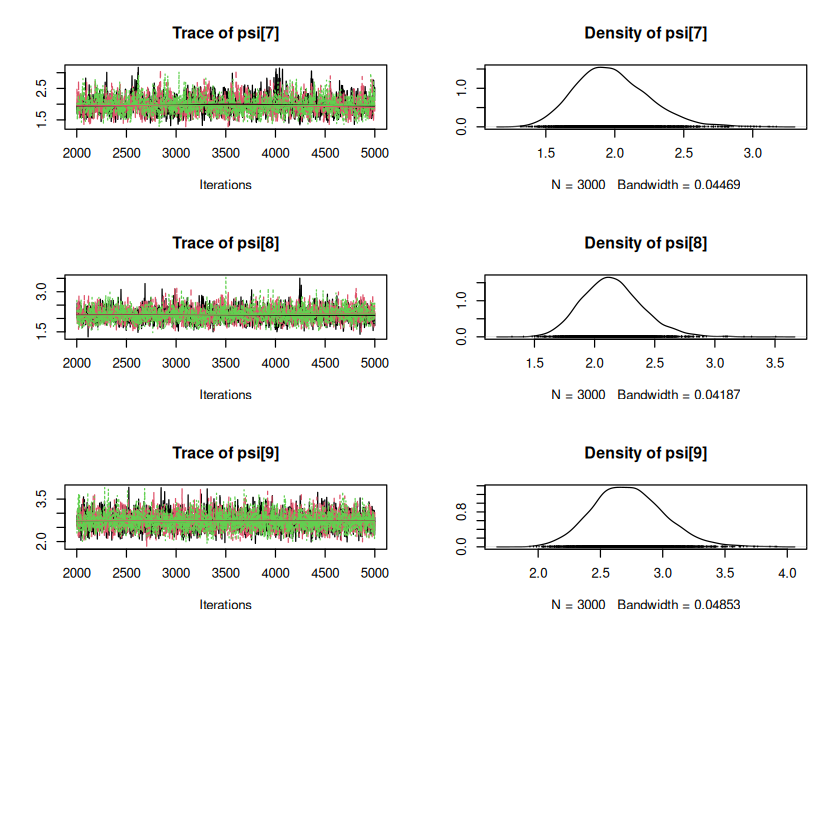

In [13]:
codaobject <- R2WinBUGS::read.bugs(model.out)
plot(codaobject)
# save.image()

##### Step 4: Obtain Bayesian statistics

To get estimates for omega_i, i.e. node `xi` (which was omitted in step 1), re-run `bugs()` with  the `parameters.to.save` updated, additional iterations (for example, 4000 or 5000) and `codaPkg = FALSE`. Note that the output results are displayed by a column vector (`xi[1,1],xi[1,2],xi[1,3],xi[2,1],xi[2,2],xi[2,3],......,xi[100,1],xi[100,2],xi[100,3]`)

The results for statistics inference, for example, the mean (the Bayesian estimates), standard deviation, Monte Carlo error, will be given in the output of `bugs()` and in the log file. To get the corresponding DIC values, set bugs()' argument `DIC = TRUE` (default).

In [14]:
model.out <- R2WinBUGS::bugs(
    data, 
    inits, 
    param, 
    model.file = model,
    n.iter = 2*n.iter,
    n.burnin = n.burnin,
    n.thin = 1,
    debug = FALSE,
    codaPkg = FALSE,
    bugs.directory = paste0(Sys.getenv("HOME"), "/.wine/drive_c/Program Files (x86)/WinBUGS14/"),
    program = "WinBUGS",
    working.directory = paste0(getwd(), "/Chapter6/bugs-output"),
    WINE = "/usr/bin/wine",
    WINEPATH = "/usr/bin/winepath"
)

model.out

Inference for Bugs model at "/home/pal_bjartan/Backup/PhD/SEM-test-model/Lee2007/Chapter4/ch4-R2OpenBUGS-model.txt", fit using WinBUGS,
 3 chains, each with 10000 iterations (first 2000 discarded)
 n.sims = 24000 iterations saved
            mean   sd   2.5%    25%    50%    75%  97.5% Rhat n.eff
alp[1]       0.0  0.1   -0.1    0.0    0.0    0.0    0.1    1  2800
alp[2]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1  1900
alp[3]       0.0  0.1   -0.1   -0.1    0.0    0.0    0.1    1  2500
alp[4]       0.1  0.1    0.0    0.1    0.1    0.2    0.3    1  3200
alp[5]       0.1  0.1    0.0    0.1    0.1    0.2    0.2    1  2000
alp[6]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1  3400
alp[7]       0.1  0.1    0.0    0.1    0.1    0.2    0.3    1  8300
alp[8]       0.0  0.1   -0.1    0.0    0.0    0.1    0.2    1  6900
alp[9]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1 17000
lam[1]       1.0  0.1    0.9    1.0    1.0    1.1    1.2    1  2300
lam[2]       0.7  0.0 